# RNN

Kaggle’s MasterCard stock dataset from May-25-2006 to Oct-11-2021 to train the LSTM and GRU models to forecast the stock price. I´m gonna show how to analyze data, preprocess the data to train it on advanced RNN models, and finally evaluate the results.

The project requires Pandas and Numpy for data manipulation, Matplotlib.pyplot for data visualization, scikit-learn for scaling and evaluation, and TensorFlow for modeling. We will also set seeds for reproducibility.

In [1]:
# Importing the libraries
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed


#set seeds for reproducibility.
#A random seed is used to ensure that results are reproducible. In other words, using this parameter makes sure that anyone who re-runs your code will get the exact same outputs. 
#Reproducibility is an extremely important concept in data science and other fields.
set_seed(455)
np.random.seed(455)

## Data Analysis

1) import the MasterCard dataset by adding the Date column to the index and converting it to DateTime format. 

2) Drop irrelevant columns from the dataset as we are only interested in stock prices, volume, and date.

The dataset has Date as index and Open, High, Low, Close, and Volume as columns. It looks like we have successfully imported a cleaned dataset.

In [2]:
dataset = pd.read_csv("Mastercard_stock_history.csv", index_col="Date", parse_dates=["Date"]).drop(["Dividends", "Stock Splits"], axis=1)
print(dataset.head())

                Open      High       Low     Close     Volume
Date                                                         
2006-05-25  3.748967  4.283869  3.739664  4.279217  395343000
2006-05-26  4.307126  4.348058  4.103398  4.179680  103044000
2006-05-30  4.183400  4.184330  3.986184  4.093164   49898000
2006-05-31  4.125723  4.219679  4.125723  4.180608   30002000
2006-06-01  4.179678  4.474572  4.176887  4.419686   62344000


Let’s focus on the High column as we are going to use it to train the model. We can also choose Close or Open columns for a model feature, but High makes more sense as it provides us information of how high the values of the share went on the given day.

In [3]:
print(dataset.describe())

              Open         High          Low        Close        Volume
count  3872.000000  3872.000000  3872.000000  3872.000000  3.872000e+03
mean    104.896814   105.956054   103.769349   104.882714  1.232250e+07
std     106.245511   107.303589   105.050064   106.168693  1.759665e+07
min       3.748967     4.102467     3.739664     4.083861  6.411000e+05
25%      22.347203    22.637997    22.034458    22.300391  3.529475e+06
50%      70.810079    71.375896    70.224002    70.856083  5.891750e+06
75%     147.688448   148.645373   146.822013   147.688438  1.319775e+07
max     392.653890   400.521479   389.747812   394.685730  3.953430e+08


The minimum stock price is $4.10, and the highest is $400.5. The mean is at $105.9 and the standard deviation $107.3, which means that stocks have high variance.

In [4]:
dataset.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

It seems that the dataset has no missing values.

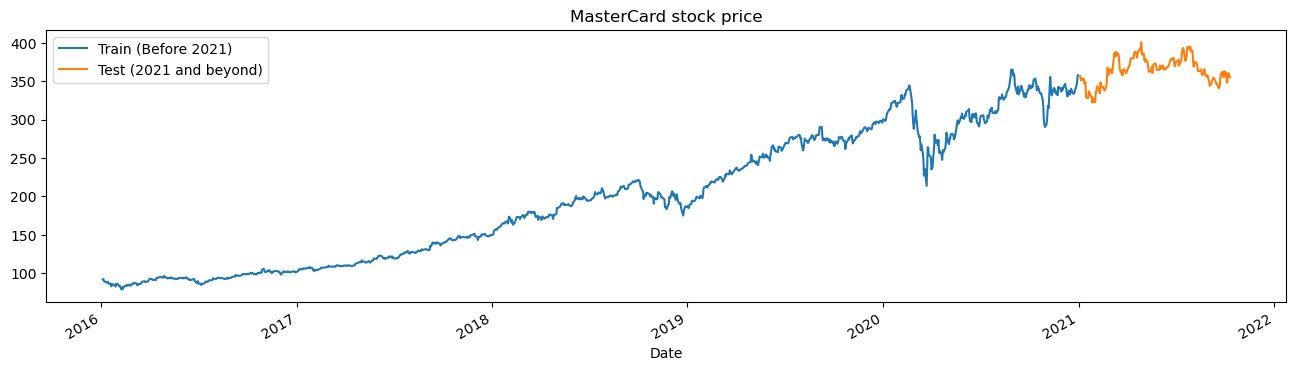

In [5]:
tstart = 2016
tend = 2020

def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", "High"].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{tend+1}":, "High"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("MasterCard stock price")
    plt.show()

train_test_plot(dataset,tstart,tend)

The train_test_plot function takes three arguments: dataset, tstart, and tend and plots a simple line graph. The tstart and tend are time limits in years. We can change these arguments to analyze specific periods. The line plot is divided into two parts: train and test. This will allow us to decide the distribution of the test dataset.

MasterCard stock prices have been on the rise since 2016. It had a dip in the first quarter of 2020 but it gained a stable position in the latter half of the year. Our test dataset consists of one year, from 2021 to 2022, and the rest of the dataset is used for training.

## Data Preprocessing

In [6]:
def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "High"].values
    test = dataset.loc[f"{tend+1}":, "High"].values
    return train, test

training_set, test_set = train_test_split(dataset, tstart, tend)

In [7]:
training_set.shape

(1259,)

In [8]:
training_set.reshape(-1, 1).shape

(1259, 1)

The train_test_split function divides the dataset into two subsets: training_set and test_set.

In [9]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

We will use the MinMaxScaler function to standardize our training set, which will help us avoid the outliers or anomalies. You can also try using StandardScaler or any other scalar function to normalize your data and improve model performance.

The split_sequence function uses a training dataset and converts it into inputs (X_train) and outputs (y_train).

In [10]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 60
features = 1
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps)

1,2,3 ------> x 4-------> y
2,3,4 ------> x 5-------> y
3,4,5 ------> x 6-------> y

In this project, we are using 60 n_steps. We can also reduce or increase the number of steps to optimize model performance.

We are working with univariate series, so the number of features is one, and we need to reshape the X_train to fit on the LSTM model. The X_train has [samples, timesteps], and we will reshape it to [samples, timesteps, features].

In [11]:
# Reshaping X_train for model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)

## LSTM Model

The model consists of a single hidden layer of LSTM and an output layer. You can experiment with the number of units, as more units will give you better results. For this experiment, we will set LSTM units to 125, tanh as activation, and set input size.

Finally, we will compile the model with an RMSprop optimizer and mean square error as a loss function.

In [12]:
# The LSTM architecture
model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="tanh", input_shape=(n_steps, features)))
model_lstm.add(Dense(units=1))
# Compiling the model
model_lstm.compile(optimizer="RMSprop", loss="mse")

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 125)               63500     
                                                                 
 dense (Dense)               (None, 1)                 126       
                                                                 
Total params: 63,626
Trainable params: 63,626
Non-trainable params: 0
_________________________________________________________________


The model will train on 50 epochs with 32 batch sizes. You can change the hyperparameters to reduce training time or improve the results. The model training was successfully completed with the best possible loss.

In [13]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
38/38 [==============================] - 5s 61ms/step - loss: 0.0189
Epoch 2/50
38/38 [==============================] - 2s 62ms/step - loss: 0.0024
Epoch 3/50
38/38 [==============================] - 2s 60ms/step - loss: 0.0021
Epoch 4/50
38/38 [==============================] - 2s 54ms/step - loss: 0.0019
Epoch 5/50
38/38 [==============================] - 2s 54ms/step - loss: 0.0015
Epoch 6/50
38/38 [==============================] - 2s 55ms/step - loss: 0.0015
Epoch 7/50
38/38 [==============================] - 2s 54ms/step - loss: 9.6528e-04
Epoch 8/50
38/38 [==============================] - 2s 54ms/step - loss: 0.0013
Epoch 9/50
38/38 [==============================] - 2s 55ms/step - loss: 0.0010
Epoch 10/50
38/38 [==============================] - 2s 56ms/step - loss: 0.0011
Epoch 11/50
38/38 [==============================] - 2s 54ms/step - loss: 8.1094e-04
Epoch 12/50
38/38 [==============================] - 2s 53ms/step - loss: 8.7650e-04
Epoch 13/50
38/38 [======

## Results

We are going to repeat preprocessing and normalize the test set. First of all we will transform then split the dataset into samples, reshape it, predict, and inverse transform the predictions into standard form.

In [14]:
dataset_total = dataset.loc[:,"High"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
#scaling
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
#prediction
predicted_stock_price = model_lstm.predict(X_test)
#inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

7/7 [==============================] - 2s 54ms/step


The plot_predictions function will plot a real versus predicted line chart. This will help us visualize the difference between actual and predicted values.

The return_rmse function takes in test and predicted arguments and prints out the root mean square error (rmse) metric.

In [15]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("MasterCard Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("MasterCard Stock Price")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))

According to the line plot below, the single-layered LSTM model has performed well.

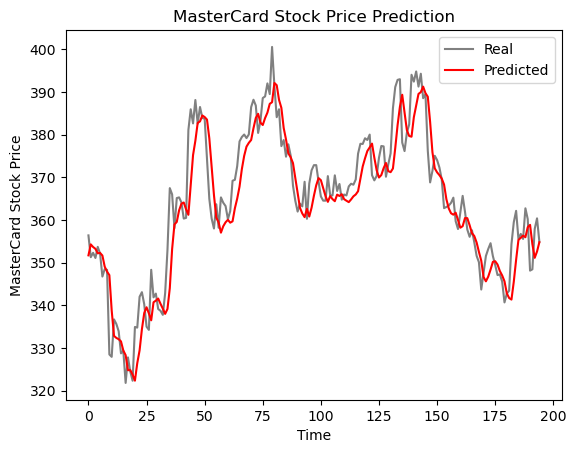

In [17]:
plot_predictions(test_set,predicted_stock_price)

In [18]:
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 6.56.


The results look promising as the model got 6.47 rmse on the test dataset.

## GRU Model

In [19]:
model_gru = Sequential()
model_gru.add(GRU(units=125, activation="tanh", input_shape=(n_steps, features)))
model_gru.add(Dense(units=1))
# Compiling the RNN
model_gru.compile(optimizer="RMSprop", loss="mse")

model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 125)               48000     
                                                                 
 dense_1 (Dense)             (None, 1)                 126       
                                                                 
Total params: 48,126
Trainable params: 48,126
Non-trainable params: 0
_________________________________________________________________


The model has successfully trained with 50 epochs and a batch size of 32.

In [20]:
model_gru.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
38/38 [==============================] - 5s 62ms/step - loss: 0.0111
Epoch 2/50
38/38 [==============================] - 2s 56ms/step - loss: 0.0016
Epoch 3/50
38/38 [==============================] - 2s 65ms/step - loss: 0.0014
Epoch 4/50
38/38 [==============================] - 2s 61ms/step - loss: 0.0013
Epoch 5/50
38/38 [==============================] - 3s 78ms/step - loss: 9.1919e-04
Epoch 6/50
38/38 [==============================] - 3s 87ms/step - loss: 0.0011
Epoch 7/50
38/38 [==============================] - 5s 126ms/step - loss: 6.5610e-04
Epoch 8/50
38/38 [==============================] - 4s 114ms/step - loss: 8.4243e-04
Epoch 9/50
38/38 [==============================] - 4s 108ms/step - loss: 6.9390e-04
Epoch 10/50
38/38 [==============================] - 3s 84ms/step - loss: 7.6979e-04
Epoch 11/50
38/38 [==============================] - 3s 76ms/step - loss: 6.4577e-04
Epoch 12/50
38/38 [==============================] - 5s 127ms/step - loss: 6.0859e-04
Epoch

7/7 [==============================] - 2s 32ms/step


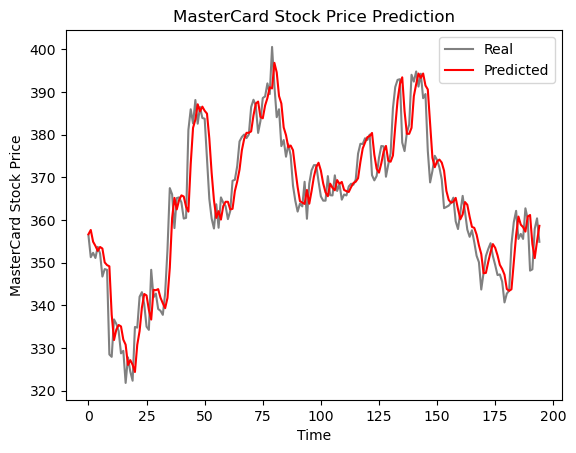

In [21]:
GRU_predicted_stock_price = model_gru.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
plot_predictions(test_set, GRU_predicted_stock_price)

As we can see, the real and predicted values are relatively close. The predicted line chart almost fits the actual values.

In [22]:
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 5.84.


GRU model got 5.95 rmse on the test dataset, which is an improvement from the LSTM model.